In [2]:
import pandas as pd
import numpy as np
data= pd.read_excel('TOT_imputed_data.xlsx')
data.drop('Label1-Mortality outcome',
  axis='columns', inplace=True)
label='Label2-SARS-CoV-2 nucleic acids'

In [4]:
#Importing the Libraries
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
#from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [5]:
#define dataset
features = np.array([f for f in data.columns if f not in [label]])
X=data[features]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [6]:
#AUTOENCODER DATASET: COMPLETE

# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*0.8)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs*0.5)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs)*0.3)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs*0.5)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*0.8)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

model.summary()

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230)]             0         
_________________________________________________________________
dense (Dense)                (None, 184)               42504     
_________________________________________________________________
batch_normalization (BatchNo (None, 184)               736       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 184)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 115)               21275     
_________________________________________________________________
batch_normalization_1 (Batch (None, 115)               460       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 115)              

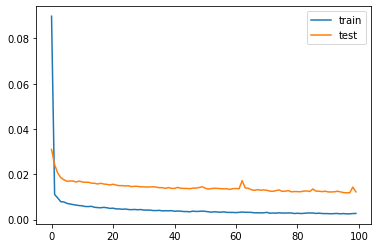

In [15]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# save the encoder to file
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('aaaaa.h5')

In [10]:
encoder

In [11]:
#DATASET: COMPLETE

# load the model from file
encoder = load_model('encoder_normal.h5')

#1.0 prepare the data
features = np.array([f for f in data.columns if f not in [label]])
X=data[features]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
print(X_train.shape,X_train_encode.shape)

#1.1 model with X_train
# define the keras model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)

#1.2 model with X_train_encode
# define the keras model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
# evaluate the keras model
_, accuracy_encode = model.evaluate(X_train_encode, y_train)

#1.3 results
print('Accuracy: %.2f' % (accuracy*100))
print('Accuracy with encoder: %.2f' % (accuracy_encode*100))

(1019, 230) (1019, 69)
32/32 [==============================] - 0s 552us/step - loss: 0.1163 - accuracy: 0.8430
Accuracy: 86.56
Accuracy with encoder: 84.30


In [7]:
#BORUTA

#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['BORUTA']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [8]:
#AUTOENCODER DATASET: BORUTA

# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*0.8)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs*0.5)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs)*0.3)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs*0.5)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*0.8)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

model.summary()

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test))


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 63)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                3200      
_________________________________________________________________
batch_normalization_4 (Batch (None, 50)                200       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 31)                1581      
_________________________________________________________________
batch_normalization_5 (Batch (None, 31)                124       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 31)                0   

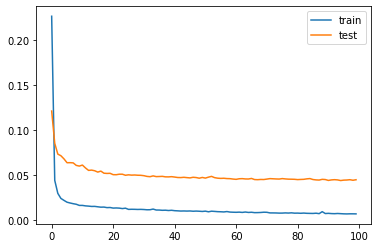

In [9]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# save the encoder to file
# save the encoder to file
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('encoder_boruta.h5')

In [10]:
#DATASET: BORUTA

# load the model from file
encoder = load_model('encoder_boruta.h5')

#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['BORUTA']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
print(X_train.shape,X_train_encode.shape)

#1.1 model with X_train
# define the keras model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)

#1.2 model with X_train_encode
# define the keras model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
# evaluate the keras model
_, accuracy_encode = model.evaluate(X_train_encode, y_train)

#1.3 results
print('Accuracy: %.2f' % (accuracy*100))
print('Accuracy with encoder: %.2f' % (accuracy_encode*100))

(1019, 63) (1019, 19)
32/32 [==============================] - 0s 804us/step - loss: 0.1467 - accuracy: 0.8037
Accuracy: 82.92
Accuracy with encoder: 80.37


In [11]:
#MRMR

#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['MRMR']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)

In [12]:
#AUTOENCODER DATASET: MRMR

# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*0.8)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs*0.5)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs)*0.3)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs*0.5)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*0.8)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

model.summary()

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
dense_24 (Dense)             (None, 49)                3087      
_________________________________________________________________
batch_normalization_8 (Batch (None, 49)                196       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 49)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 31)                1550      
_________________________________________________________________
batch_normalization_9 (Batch (None, 31)                124       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 31)                0   

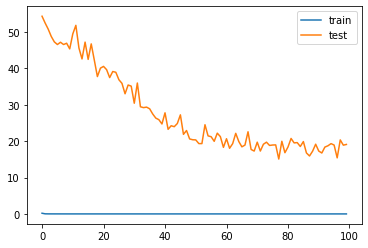

In [13]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# save the encoder to file
# save the encoder to file
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('encoder_mrmr.h5')

In [14]:
#DATASET: MRMR

# load the model from file
encoder = load_model('encoder_mrmr.h5')

#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['MRMR']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
print(X_train.shape,X_train_encode.shape)

#1.1 model with X_train
# define the keras model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)

#1.2 model with X_train_encode
# define the keras model
model = Sequential()
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
# evaluate the keras model
_, accuracy_encode = model.evaluate(X_train_encode, y_train)

#1.3 results
print('Accuracy: %.2f' % (accuracy*100))
print('Accuracy with encoder: %.2f' % (accuracy_encode*100))

(1019, 62) (1019, 19)
32/32 [==============================] - 0s 740us/step - loss: 0.1603 - accuracy: 0.7704
Accuracy: 75.66
Accuracy with encoder: 77.04


In [15]:
#UNION BORUTA MRMR

#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['UNION']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [16]:
#AUTOENCODER DATASET: UNION

# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*0.8)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs*0.5)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs)*0.3)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs*0.5)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*0.8)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

model.summary()

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test))


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 114)]             0         
_________________________________________________________________
dense_36 (Dense)             (None, 91)                10465     
_________________________________________________________________
batch_normalization_12 (Batc (None, 91)                364       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 91)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 57)                5244      
_________________________________________________________________
batch_normalization_13 (Batc (None, 57)                228       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 57)                0   

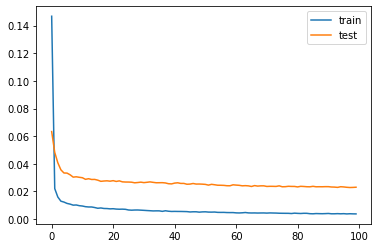

In [17]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# save the encoder to file
# save the encoder to file
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('encoder_union.h5')

In [18]:
#INTERSECT BORUTA MRMR

#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['INTERSECT']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y.to_numpy()

# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [19]:
#AUTOENCODER DATASET: INTERSECT

# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*0.8)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs*0.5)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs)*0.3)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs*0.5)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*0.8)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

model.summary()

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16, verbose=2, validation_data=(X_test,X_test))


Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                140       
_________________________________________________________________
batch_normalization_16 (Batc (None, 10)                40        
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 10)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 6)                 66        
_________________________________________________________________
batch_normalization_17 (Batc (None, 6)                 24        
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6)                 0   

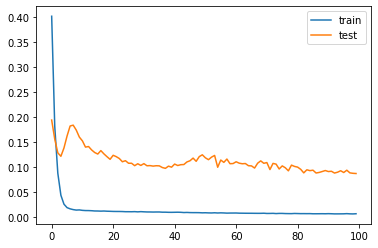

In [20]:
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# save the encoder to file
# save the encoder to file
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
encoder.save('encoder_intersect.h5')

In [21]:
#FIT SU TEST

In [12]:
#COMPLETE
normal_acc=[]
encoder_acc=[]
# load the model from file
encoder = load_model('encoder_normal.h5',compile=False)
skf = StratifiedKFold(n_splits=3)
features = np.array([f for f in data.columns if f not in [label]])
X=data[features]
X=X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y=y.to_numpy()
y_pred=y-y
y_pred=y_pred.reshape(-1,1)
y_pred_encode=y-y
y_pred_encode=y_pred_encode.reshape(-1,1)
for x in y_pred:
    if x==1:
        print("aaaaaaa")
for train_index, test_index in skf.split(X, y):
    
    # mi creo i punti di train e di test
    X_train, X_test = X[train_index,:], X[test_index,:]
    #creo le label del train e quelle del test
    y_train, y_test = y[train_index], y[test_index]
    # scale data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train = t.transform(X_train)
    X_test = t.transform(X_test)

    # encode the train data
    X_train_encode = encoder.predict(X_train)
    # encode the test data
    X_test_encode = encoder.predict(X_test)
    
    #1.1 model with X_train
    # define the keras model
    model=Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy = model.evaluate(X_test, y_test)
    #normal_acc.append(accuracy)
    y_pred[test_index]=model.predict(X_test)
    
    #1.2 model with X_train_encode
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy_encode = model.evaluate(X_test_encode, y_test)
    #encoder_acc.append(accuracy_encode)
    y_pred_encode[test_index]=model.predict(X_test_encode)
    
print("accuracy WITHOUT encoder:      ",accuracy_score(y,y_pred))
print("accuracy WITH encoder:         ",accuracy_score(y,y_pred_encode))
print("f1 score WITHOUT encoder:      ",f1_score(y, y_pred, average='weighted'))
print("f1 score WITH encoder:         ",f1_score(y, y_pred_encode, average='weighted'))
print("precision WITHOUT encoder:     ",precision_score(y, y_pred, average='weighted'))
print("precision WITH encoder:        ",precision_score(y, y_pred_encode, average='weighted'))
print("recall WITHOUT encoder:        ",recall_score(y, y_pred, average='weighted'))
print("recall WITH encoder:           ",recall_score(y, y_pred_encode, average='weighted'))
print("roc auc score WITHOUT encoder: ",roc_auc_score(y, y_pred))
print("roc auc score WITH encoder:    ",roc_auc_score(y, y_pred_encode))

accuracy WITHOUT encoder:       0.6219592373438527
accuracy WITH encoder:          0.6232741617357002
f1 score WITHOUT encoder:       0.4891432392173472
f1 score WITH encoder:          0.48185716052369115
precision WITHOUT encoder:      0.585643843336151
precision WITH encoder:         0.689837785514668
recall WITHOUT encoder:         0.6219592373438527
recall WITH encoder:            0.6232741617357002
roc auc score WITHOUT encoder:  0.5042576058201058
roc auc score WITH encoder:     0.5029431216931217


In [23]:
#BORUTA
normal_acc=[]
encoder_acc=[]
# load the model from file
encoder = load_model('encoder_boruta.h5',compile=False)
#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['BORUTA']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X=X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y=y.to_numpy()
y_pred=y-y
y_pred=y_pred.reshape(-1,1)
y_pred_encode=y-y
y_pred_encode=y_pred_encode.reshape(-1,1)
for train_index, test_index in skf.split(X, y):
    
    # mi creo i punti di train e di test
    X_train, X_test = X[train_index,:], X[test_index,:]
    #creo le label del train e quelle del test
    y_train, y_test = y[train_index], y[test_index]
    # scale data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train = t.transform(X_train)
    X_test = t.transform(X_test)

    # encode the train data
    X_train_encode = encoder.predict(X_train)
    # encode the test data
    X_test_encode = encoder.predict(X_test)
    
    #1.1 model with X_train
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy = model.evaluate(X_test, y_test)
    #normal_acc.append(accuracy)
    y_pred[test_index]=model.predict(X_test)
    
    #1.2 model with X_train_encode
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy_encode = model.evaluate(X_test_encode, y_test)
    #encoder_acc.append(accuracy_encode)
    y_pred_encode[test_index]=model.predict(X_test_encode)

print("accuracy WITHOUT encoder:      ",accuracy_score(y,y_pred))
print("accuracy WITH encoder:         ",accuracy_score(y,y_pred_encode))
print("f1 score WITHOUT encoder:      ",f1_score(y, y_pred, average='weighted'))
print("f1 score WITH encoder:         ",f1_score(y, y_pred_encode, average='weighted'))
print("precision WITHOUT encoder:     ",precision_score(y, y_pred, average='weighted'))
print("precision WITH encoder:        ",precision_score(y, y_pred_encode, average='weighted'))
print("recall WITHOUT encoder:        ",recall_score(y, y_pred, average='weighted'))
print("recall WITH encoder:           ",recall_score(y, y_pred_encode, average='weighted'))
print("roc auc score WITHOUT encoder: ",roc_auc_score(y, y_pred))
print("roc auc score WITH encoder:    ",roc_auc_score(y, y_pred_encode))

accuracy WITHOUT encoder:       0.621301775147929
accuracy WITH encoder:          0.6206443129520053
f1 score WITHOUT encoder:       0.47855612616401005
f1 score WITH encoder:          0.4758692703769939
precision WITHOUT encoder:      0.5755637294098832
precision WITH encoder:         0.38586110246029276
recall WITHOUT encoder:         0.621301775147929
recall WITH encoder:            0.6206443129520053
roc auc score WITHOUT encoder:  0.5006779100529102
roc auc score WITH encoder:     0.49947089947089945


In [24]:
#MRMR
normal_acc=[]
encoder_acc=[]
# load the model from file
encoder = load_model('encoder_mrmr.h5',compile=False)
#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['MRMR']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X=X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y=y.to_numpy()
y_pred=y-y
y_pred=y_pred.reshape(-1,1)
y_pred_encode=y-y
y_pred_encode=y_pred_encode.reshape(-1,1)
for train_index, test_index in skf.split(X, y):
    
    # mi creo i punti di train e di test
    X_train, X_test = X[train_index,:], X[test_index,:]
    #creo le label del train e quelle del test
    y_train, y_test = y[train_index], y[test_index]
    # scale data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train = t.transform(X_train)
    X_test = t.transform(X_test)

    # encode the train data
    X_train_encode = encoder.predict(X_train)
    # encode the test data
    X_test_encode = encoder.predict(X_test)
    
    #1.1 model with X_train
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy = model.evaluate(X_test, y_test)
    #normal_acc.append(accuracy)
    y_pred[test_index]=model.predict(X_test)
        
    #1.2 model with X_train_encode
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy_encode = model.evaluate(X_test_encode, y_test)
    #encoder_acc.append(accuracy_encode)
    y_pred_encode[test_index]=model.predict(X_test_encode)

print("accuracy WITHOUT encoder:      ",accuracy_score(y,y_pred))
print("accuracy WITH encoder:         ",accuracy_score(y,y_pred_encode))
print("f1 score WITHOUT encoder:      ",f1_score(y, y_pred, average='weighted'))
print("f1 score WITH encoder:         ",f1_score(y, y_pred_encode, average='weighted'))
print("precision WITHOUT encoder:     ",precision_score(y, y_pred, average='weighted'))
print("precision WITH encoder:        ",precision_score(y, y_pred_encode, average='weighted'))
print("recall WITHOUT encoder:        ",recall_score(y, y_pred, average='weighted'))
print("recall WITH encoder:           ",recall_score(y, y_pred_encode, average='weighted'))
print("roc auc score WITHOUT encoder: ",roc_auc_score(y, y_pred))
print("roc auc score WITH encoder:    ",roc_auc_score(y, y_pred_encode))

accuracy WITHOUT encoder:       0.6232741617357002
accuracy WITH encoder:          0.6219592373438527
f1 score WITHOUT encoder:       0.4806845268025458
f1 score WITH encoder:          0.47768601467378075
precision WITHOUT encoder:      0.7654769979184695
precision WITH encoder:         0.7649680784802242
recall WITHOUT encoder:         0.6232741617357002
recall WITH encoder:            0.6219592373438527
roc auc score WITHOUT encoder:  0.5026041666666666
roc auc score WITH encoder:     0.5008680555555556


In [25]:
#UNION
normal_acc=[]
encoder_acc=[]
# load the model from file
encoder = load_model('encoder_union.h5',compile=False)
#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx', sep=';',decimal='.')
boruta_selected=feature_selection[feature_selection['UNION']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X=X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y=y.to_numpy()
y_pred=y-y
y_pred=y_pred.reshape(-1,1)
y_pred_encode=y-y
y_pred_encode=y_pred_encode.reshape(-1,1)
for train_index, test_index in skf.split(X, y):
    
    # mi creo i punti di train e di test
    X_train, X_test = X[train_index,:], X[test_index,:]
    #creo le label del train e quelle del test
    y_train, y_test = y[train_index], y[test_index]
    # scale data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train = t.transform(X_train)
    X_test = t.transform(X_test)

    # encode the train data
    X_train_encode = encoder.predict(X_train)
    # encode the test data
    X_test_encode = encoder.predict(X_test)
    
    #1.1 model with X_train
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy = model.evaluate(X_test, y_test)
    #normal_acc.append(accuracy)
    y_pred[test_index]=model.predict(X_test)
        
    #1.2 model with X_train_encode
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy_encode = model.evaluate(X_test_encode, y_test)
    #encoder_acc.append(accuracy_encode)
    y_pred_encode[test_index]=model.predict(X_test_encode)

print("accuracy WITHOUT encoder:      ",accuracy_score(y,y_pred))
print("accuracy WITH encoder:         ",accuracy_score(y,y_pred_encode))
print("f1 score WITHOUT encoder:      ",f1_score(y, y_pred, average='weighted'))
print("f1 score WITH encoder:         ",f1_score(y, y_pred_encode, average='weighted'))
print("precision WITHOUT encoder:     ",precision_score(y, y_pred, average='weighted'))
print("precision WITH encoder:        ",precision_score(y, y_pred_encode, average='weighted'))
print("recall WITHOUT encoder:        ",recall_score(y, y_pred, average='weighted'))
print("recall WITH encoder:           ",recall_score(y, y_pred_encode, average='weighted'))
print("roc auc score WITHOUT encoder: ",roc_auc_score(y, y_pred))
print("roc auc score WITH encoder:    ",roc_auc_score(y, y_pred_encode))

accuracy WITHOUT encoder:       0.6278763971071664
accuracy WITH encoder:          0.6219592373438527
f1 score WITHOUT encoder:       0.4965956531945022
f1 score WITH encoder:          0.4788719073498496
precision WITHOUT encoder:      0.6731133879189022
precision WITH encoder:         0.6388349665941639
recall WITHOUT encoder:         0.6278763971071664
recall WITH encoder:            0.6219592373438527
roc auc score WITHOUT encoder:  0.5103753306878307
roc auc score WITH encoder:     0.5012070105820106


In [16]:
#INTERSECT
skf = StratifiedKFold(n_splits=3)
normal_acc=[]
encoder_acc=[]
# load the model from file
encoder = load_model('encoder_intersect.h5',compile=False)
#1.0 prepare the data
feature_selection= pd.read_excel('L2_comp.xlsx')
boruta_selected=feature_selection[feature_selection['INTERSECT']>=600]
feature_selected_boruta=boruta_selected['features']
X=data[feature_selected_boruta]
X=X.to_numpy()
y=data[label].map({'Positive': 0, 'Negative':1})
y=y.to_numpy()
y_pred=y-y
y_pred=y_pred.reshape(-1,1)
y_pred_encode=y-y
y_pred_encode=y_pred_encode.reshape(-1,1)
for train_index, test_index in skf.split(X, y):
    
    # mi creo i punti di train e di test
    X_train, X_test = X[train_index,:], X[test_index,:]
    #creo le label del train e quelle del test
    y_train, y_test = y[train_index], y[test_index]
    # scale data
    t = MinMaxScaler()
    t.fit(X_train)
    X_train = t.transform(X_train)
    X_test = t.transform(X_test)

    # encode the train data
    X_train_encode = encoder.predict(X_train)
    # encode the test data
    X_test_encode = encoder.predict(X_test)
    
    #1.1 model with X_train
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy = model.evaluate(X_test, y_test)
    #normal_acc.append(accuracy)
    y_pred[test_index]=model.predict(X_test)

    #1.2 model with X_train_encode
    # define the keras model
    model = Sequential()
    model.add(Dense(12, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(X_train_encode, y_train, epochs=150, batch_size=10,verbose=0)
    # evaluate the keras model
    #_, accuracy_encode = model.evaluate(X_test_encode, y_test)
    #encoder_acc.append(accuracy_encode)
    y_pred_encode[test_index]=model.predict(X_test_encode)

print("accuracy WITHOUT encoder:      ",accuracy_score(y,y_pred))
print("accuracy WITH encoder:         ",accuracy_score(y,y_pred_encode))
print("f1 score WITHOUT encoder:      ",f1_score(y, y_pred, average='weighted'))
print("f1 score WITH encoder:         ",f1_score(y, y_pred_encode, average='weighted'))
print("precision WITHOUT encoder:     ",precision_score(y, y_pred, average='weighted'))
print("precision WITH encoder:        ",precision_score(y, y_pred_encode, average='weighted'))
print("recall WITHOUT encoder:        ",recall_score(y, y_pred, average='weighted'))
print("recall WITH encoder:           ",recall_score(y, y_pred_encode, average='weighted'))
print("roc auc score WITHOUT encoder: ",roc_auc_score(y, y_pred))
print("roc auc score WITH encoder:    ",roc_auc_score(y, y_pred_encode))

accuracy WITHOUT encoder:       0.621301775147929
accuracy WITH encoder:          0.621301775147929
f1 score WITHOUT encoder:       0.4761801926316244
f1 score WITH encoder:          0.4761801926316244
precision WITHOUT encoder:      0.3860158958019677
precision WITH encoder:         0.3860158958019677
recall WITHOUT encoder:         0.621301775147929
recall WITH encoder:            0.621301775147929
roc auc score WITHOUT encoder:  0.5
roc auc score WITH encoder:     0.5


C:\Users\marco\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
